# Функциональное зонирование территории и генерация зданий

Этот Notebook представляет собой инструмент для автоматического функционального зонирования территории и генерации схем размещения зданий на основе входных геоданных.

**Основные этапы работы:**

1.  **Загрузка данных:** Загрузка GeoJSON файла, содержащего полигон участка и зоны ограничений.
2.  **Обработка ограничений:** Буферизация зон ограничений и определение доступной для застройки территории.
3.  **Генерация дорожной сети:** Создание дорожной сети внутри доступной территории на основе размера участка.
4.  **Функциональное зонирование:** Разделение доступной территории на функциональные зоны (жилая, коммерческая, парковая) в соответствии с заданными пропорциями.
5.  **Генерация зданий:** Размещение зданий в жилых и коммерческих зонах с учетом плотности застройки и типов зон.
6.  **Визуализация результатов:** Отображение зон, дорог и зданий на карте.
7.  **Экспорт данных:** Сохранение результатов зонирования и размещения зданий в GeoJSON файл.

**Библиотеки:**

*   `geopandas`: Для работы с геопространственными данными.
*   `shapely`: Для геометрических операций.
*   `matplotlib`: Для визуализации.
*   `numpy`: Для численных расчетов.
*   `logging`: Для логирования процесса выполнения.
*   `random`: Для генерации случайных параметров.
*   `json` и `codecs`: Для экспорта в GeoJSON.

**Перед началом работы:**

*   Установите необходимые библиотеки: `pip install geopandas shapely matplotlib numpy jupytext`.
*   Убедитесь, что входной GeoJSON файл соответствует ожидаемой структуре (наличие полигона 'Зона застройки' и зон ограничений с атрибутом 'restriction': 'no_build').
*   При необходимости настройте параметры зонирования и генерации в разделе "Константы и параметры".

# ## 1. Импорт библиотек и настройка логирования

In [86]:
import geopandas as gpd
from shapely.geometry import Polygon, Point, LineString, MultiPolygon
from shapely.ops import unary_union, polygonize
from shapely import affinity
import matplotlib.pyplot as plt
import numpy as np
import logging
import random
import json
import codecs
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from typing import Optional, Dict, Tuple, List

# Настройка логирования для отслеживания процесса выполнения и ошибок
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# ## 2. Константы и параметры

In [87]:
# Система координат для проекта (UTM Zone 37N, подходит для территорий в Европейской части России)
TARGET_CRS = "EPSG:32637"
# Система координат по умолчанию (WGS 84)
DEFAULT_CRS = "EPSG:4326"

# Расстояние буфера для зон ограничений (в метрах)
RESTRICTION_BUFFER_DISTANCE = 1
# Порог площади для определения размера участка (в кв.м) - меньше этого значения считается малым
SMALL_AREA_THRESHOLD = 15000
# Максимальная допустимая плотность застройки (доля территории, которая может быть застроена)
DENSITY_LIMIT = 0.7
# Соотношения площадей для разных типов зон по умолчанию
DEFAULT_ZONE_RATIOS = {'residential': 0.7, 'commercial': 0.2, 'park': 0.1}

# Параметры дорожной сети для больших участков
ROAD_SPACING_LARGE = 90 # Расстояние между дорогами
BOUNDARY_OFFSET_LARGE = -1 # Отступ дорог от границы участка

# Параметры дорожной сети для малых участков
ROAD_SPACING_SMALL = 20 # Расстояние между дорогами
BOUNDARY_OFFSET_SMALL = -5 # Отступ дорог от границы участка

# Общий отступ для зданий от границ зон и других зданий (в метрах)
BUILDING_PADDING = 10.0
# Отступ контурной дороги в малых зонах
ROAD_OFFSET_SMALL_ZONE = -1
# Минимальное соотношение длины сегмента дороги к шагу сетки дорог (для фильтрации коротких сегментов)
MIN_ROAD_LENGTH_RATIO = 0.6

# Цвета для визуализации разных типов зон
ZONE_COLORS = {
    'residential_commercial_building': 'lightcoral', # Цвет для зданий в малых жилых зонах
    'road': 'gray', # Цвет для дорог
    'park': 'lightseagreen', # Цвет для парков в малых зонах
    'residential': 'lightyellow', # Цвет для жилых зон в больших участках
    'commercial_center': 'lightsalmon', # Цвет для коммерческих центров в больших участках
    'park_area': 'lightgreen' # Цвет для парковых зон в больших участках
}

# Размеры зданий для малых участков (минимальная и максимальная площадь в кв.м)
RESIDENTIAL_BUILDING_SIZE_RANGE_SMALL = (1500, 3000)
COMMERCIAL_BUILDING_SIZE_RANGE_SMALL = (2000, 25000)
# Размеры зданий для больших участков (минимальная и максимальная площадь в кв.м)
RESIDENTIAL_BUILDING_SIZE_RANGE_LARGE = (2500, 5000)
COMMERCIAL_BUILDING_SIZE_RANGE_LARGE = (15000, 40000)

# Параметры смещения для зданий в малых жилых зонах
BUILDING_OUTER_OFFSET_SMALL = -0.1 # Внешний отступ
BUILDING_INNER_OFFSET_SMALL = -10 # Внутренний отступ

# Диапазоны соотношения сторон зданий (ширина к длине)
RESIDENTIAL_BUILDING_ASPECT_RATIO_RANGE = (1.2, 2.5) # Для жилых зданий
COMMERCIAL_BUILDING_ASPECT_RATIO_RANGE = (1.5, 4.0) # Для коммерческих зданий

# ## 3. Функции для работы с GeoJSON

In [88]:
def load_geojson(filepath: str, target_crs: str = TARGET_CRS) -> Optional[gpd.GeoDataFrame]:
    """
    Загружает GeoJSON файл и перепроецирует его в целевую систему координат.

    Args:
        filepath (str): Путь к GeoJSON файлу.
        target_crs (str, optional): Целевая система координат. По умолчанию TARGET_CRS.

    Returns:
        Optional[gpd.GeoDataFrame]: GeoDataFrame в целевой системе координат или None в случае ошибки.
    """
    try:
        gdf = gpd.read_file(filepath)
        if gdf.crs is None:
            logging.warning(f"GeoJSON файл '{filepath}' не имеет информации о CRS. Предполагается система координат WGS 84 ({DEFAULT_CRS}).")
            gdf.crs = DEFAULT_CRS
        gdf_projected = gdf.to_crs(target_crs)
        logging.info(f"GeoJSON файл '{filepath}' успешно загружен и перепроецирован в {target_crs}.")
        return gdf_projected
    except FileNotFoundError:
        logging.error(f"Файл не найден: {filepath}")
        return None
    except Exception as e:
        logging.error(f"Ошибка при чтении или перепроекции GeoJSON файла '{filepath}': {e}")
        return None

def extract_site_and_restrictions(input_gdf: gpd.GeoDataFrame) -> Tuple[Optional[Polygon], Optional[gpd.GeoDataFrame]]:
    """
    Извлекает полигон участка застройки и зоны ограничений из GeoDataFrame.

    Предполагается, что GeoDataFrame содержит:
    - Полигон участка застройки с атрибутом 'name' == 'Зона застройки'.
    - Полигоны зон ограничений с атрибутом 'restriction' == 'no_build'.

    Args:
        input_gdf (gpd.GeoDataFrame): Входной GeoDataFrame с участком и ограничениями.

    Returns:
        Tuple[Optional[Polygon], Optional[gpd.GeoDataFrame]]:
            Полигон участка застройки и GeoDataFrame с зонами ограничений.
            Возвращает None для любого из элементов кортежа в случае ошибки или отсутствия данных.
    """
    if input_gdf is None or input_gdf.empty:
        logging.error("Входной GeoDataFrame пуст или не определен.")
        return None, None

    site_polygon = None
    restrictions_features = []

    for _, row in input_gdf.iterrows():
        if row['name'] == 'Зона застройки':
            site_polygon = row['geometry']
        elif 'restriction' in row and row['restriction'] == 'no_build':
            restrictions_features.append(row)

    if site_polygon is None:
        logging.error("Не найден полигон 'Зона застройки' в GeoJSON.")
        return None, None

    restrictions_gdf = gpd.GeoDataFrame(restrictions_features, crs=input_gdf.crs)
    logging.info("Полигон участка и зоны ограничений успешно извлечены.")
    return site_polygon, restrictions_gdf

def process_restrictions_and_visualize(site_polygon: Polygon, restrictions_gdf: Optional[gpd.GeoDataFrame], restriction_buffer_distance: float = RESTRICTION_BUFFER_DISTANCE) -> Optional[Polygon]:
    """
    Обрабатывает зоны ограничений, создает буфер вокруг них и вычисляет доступную для застройки территорию.
    Визуализирует участок, ограничения и доступную территорию на графике.

    Args:
        site_polygon (Polygon): Полигон участка застройки.
        restrictions_gdf (Optional[gpd.GeoDataFrame]): GeoDataFrame с зонами ограничений. Может быть None.
        restriction_buffer_distance (float, optional): Расстояние буфера вокруг зон ограничений в метрах. По умолчанию RESTRICTION_BUFFER_DISTANCE.

    Returns:
        Optional[Polygon]: Полигон доступной для застройки территории или None в случае ошибки.
    """
    if site_polygon is None:
        logging.error("Полигон участка не определен.")
        return None

    # Создаем буфер вокруг зон ограничений, если они есть
    if restrictions_gdf is not None and not restrictions_gdf.empty:
        combined_restrictions = unary_union([geom.buffer(restriction_buffer_distance) for geom in restrictions_gdf.geometry])
    else:
        combined_restrictions = None
        logging.info("Зоны ограничений отсутствуют или не заданы.")

    # Вычисляем доступную для застройки территорию, вычитая зоны ограничений из участка
    buildable_area = site_polygon.difference(combined_restrictions) if combined_restrictions else site_polygon

    # Визуализация участка, ограничений и доступной территории
    fig, ax = plt.subplots(figsize=(10, 10))

    gpd.GeoSeries(site_polygon).plot(ax=ax, facecolor='lightgreen', edgecolor='black', label='Участок')

    if combined_restrictions:
        restriction_label = 'Ограничения (с буфером)'
        original_restriction_label = 'Исходные ограничения'

        # Обработка MultiPolygon ограничений для корректного отображения легенды
        if hasattr(combined_restrictions, 'geoms'):
            for restriction_geom in combined_restrictions.geoms:
                gpd.GeoSeries(restriction_geom).plot(ax=ax, facecolor='lightcoral', edgecolor='red', label=restriction_label if restriction_label else None, alpha=0.7)
                restriction_label = None # Метка легенды добавляется только один раз
            for restriction_geom in unary_union(restrictions_gdf.geometry).geoms:
                 gpd.GeoSeries(restriction_geom).plot(ax=ax, facecolor='none', edgecolor='darkred', linestyle='--', label=original_restriction_label if original_restriction_label else None, alpha=0.7)
                 original_restriction_label = None # Метка легенды добавляется только один раз
        else:
            gpd.GeoSeries(combined_restrictions).plot(ax=ax, facecolor='lightcoral', edgecolor='red', label=restriction_label, alpha=0.7)
            gpd.GeoSeries(unary_union(restrictions_gdf.geometry)).plot(ax=ax, facecolor='none', edgecolor='darkred', linestyle='--', label=original_restriction_label, alpha=0.7)

    gpd.GeoSeries(buildable_area).plot(ax=ax, facecolor='lightblue', edgecolor='blue', label='Доступная территория')

    ax.set_title('План участка с ограничениями')
    ax.legend(loc='upper left')
    ax.set_aspect('equal', adjustable='box')
    plt.show()

    logging.info(f"Площадь доступной территории: {buildable_area.area:.2f} кв.м.")
    return buildable_area


# ## 4. Функции для генерации дорожной сети

In [89]:
def generate_boundary_and_internal_roads(buildable_area: Polygon, crs: str, boundary_offset_large: float = BOUNDARY_OFFSET_LARGE, road_spacing_large: float = ROAD_SPACING_LARGE,
                                        boundary_offset_small: float = BOUNDARY_OFFSET_SMALL, road_spacing_small: float = ROAD_SPACING_SMALL,
                                        min_road_length_ratio: float = MIN_ROAD_LENGTH_RATIO, small_area_threshold: float = SMALL_AREA_THRESHOLD) -> Optional[gpd.GeoDataFrame]:
    """
    Генерирует дорожную сеть, состоящую из внешней (граничной) дороги и внутренней сетки дорог,
    адаптированную для больших и малых участков.

    Args:
        buildable_area (Polygon): Полигон доступной для застройки территории.
        crs (str): Система координат для выходного GeoDataFrame.
        boundary_offset_large (float, optional): Отступ граничной дороги для больших участков. По умолчанию BOUNDARY_OFFSET_LARGE.
        road_spacing_large (float, optional): Шаг сетки внутренних дорог для больших участков. По умолчанию ROAD_SPACING_LARGE.
        boundary_offset_small (float, optional): Отступ граничной дороги для малых участков. По умолчанию BOUNDARY_OFFSET_SMALL.
        road_spacing_small (float, optional): Шаг сетки внутренних дорог для малых участков. По умолчанию ROAD_SPACING_SMALL.
        min_road_length_ratio (float, optional): Минимальное соотношение длины сегмента дороги к шагу сетки для фильтрации коротких дорог. По умолчанию MIN_ROAD_LENGTH_RATIO.
        small_area_threshold (float, optional): Порог площади для определения типа участка (малый/большой). По умолчанию SMALL_AREA_THRESHOLD.

    Returns:
        Optional[gpd.GeoDataFrame]: GeoDataFrame с дорожной сетью (граничные и внутренние дороги) или None в случае ошибки.
    """
    if buildable_area is None:
        logging.error("Полигон доступной территории не определен.")
        return None

    # Определение параметров дорожной сети в зависимости от размера участка
    is_large_area = buildable_area.area > small_area_threshold
    boundary_offset = boundary_offset_large if is_large_area else boundary_offset_small
    road_spacing = road_spacing_large if is_large_area else road_spacing_small
    area_type = "большой" if is_large_area else "малый"
    logging.info(f"Участок {area_type} ({buildable_area.area:.2f} кв.м), используется стратегия генерации дорог для {area_type} участка.")

    # Генерация граничной дороги путем создания буфера с отрицательным смещением от участка
    boundary_road_polygon = buildable_area.buffer(boundary_offset)
    # В случае MultiPolygon выбираем полигон с наибольшей площадью (основной контур участка)
    if boundary_road_polygon.geom_type == 'MultiPolygon':
        boundary_road_polygon = max(boundary_road_polygon.geoms, key=lambda geom: geom.area)
    boundary_road = boundary_road_polygon.exterior # Извлекаем внешнюю границу как LineString

    # Генерация сетки горизонтальных и вертикальных линий для внутренних дорог
    minx, miny, maxx, maxy = buildable_area.bounds
    horizontal_lines = [LineString([(minx, y), (maxx, y)]) for y in np.arange(miny, maxy, road_spacing)]
    vertical_lines = [LineString([(x, miny), (x, maxy)]) for x in np.arange(minx, maxx, road_spacing)]

    internal_road_segments_initial = []
    # Обрезка линий сетки полигоном с граничной дорогой для получения сегментов внутренних дорог
    for line in horizontal_lines + vertical_lines:
        intersection = boundary_road_polygon.intersection(line)
        if not intersection.is_empty:
            if intersection.geom_type == 'LineString':
                internal_road_segments_initial.append(intersection)
            elif intersection.geom_type == 'MultiLineString':
                internal_road_segments_initial.extend(intersection.geoms)

    # Фильтрация коротких сегментов дорог
    min_road_segment_length = road_spacing * min_road_length_ratio
    internal_roads_filtered_segments = [seg for seg in internal_road_segments_initial if seg.length >= min_road_segment_length]
    deleted_segments_len = sum([seg.length for seg in internal_road_segments_initial if seg.length < min_road_segment_length])
    if deleted_segments_len > 0:
        logging.info(f"Удалено коротких сегментов дорог общей длиной: {deleted_segments_len:.2f}м (минимальная длина сегмента: {min_road_segment_length:.2f}м).")

    # Объединение граничной дороги и отфильтрованных внутренних дорог в GeoDataFrame
    roads_geometries = [boundary_road] + internal_roads_filtered_segments
    road_types = ['boundary'] + ['internal'] * len(internal_roads_filtered_segments) # Назначение типов дорог
    road_network_gdf = gpd.GeoDataFrame(geometry=roads_geometries, data={'type': road_types}, crs=crs)

    logging.info("Дорожная сеть успешно сгенерирована.")
    return road_network_gdf

# ## 5. Функции для определения типов зон и целевых площадей

In [90]:
def define_zone_types_and_target_areas(buildable_area: Polygon, density_limit: float = DENSITY_LIMIT, zone_ratios: Optional[Dict[str, float]] = None) -> Optional[Dict[str, float]]:
    """
    Определяет типы функциональных зон (жилая, коммерческая, парковая) и вычисляет их целевые площади
    на основе общей площади доступной территории и заданных пропорций.

    Args:
        buildable_area (Polygon): Полигон доступной для застройки территории.
        density_limit (float, optional): Максимальная допустимая плотность застройки. По умолчанию DENSITY_LIMIT.
        zone_ratios (Optional[Dict[str, float]], optional): Словарь с соотношениями площадей для разных типов зон.
            Ключи - типы зон ('residential', 'commercial', 'park'), значения - доли от общей площади застройки.
            Если None, используются DEFAULT_ZONE_RATIOS.

    Returns:
        Optional[Dict[str, float]]: Словарь с целевыми площадями для каждого типа зоны или None в случае ошибки.
    """
    if buildable_area is None:
        logging.error("Полигон доступной территории не определен.")
        return None
    if not 0 <= density_limit <= 1:
        logging.error(f"Недопустимое значение плотности застройки: {density_limit}. Плотность должна быть в диапазоне от 0 до 1.")
        return None

    zone_types = ['residential', 'commercial', 'park'] # Список типов зон
    max_build_area = buildable_area.area * density_limit # Вычисление общей площади, доступной для застройки
    zone_ratios = zone_ratios if zone_ratios else DEFAULT_ZONE_RATIOS # Использование заданных или дефолтных пропорций зон

    logging.info(f"Используются следующие соотношения площадей зон: {zone_ratios}.")

    # Вычисление целевых площадей для каждого типа зоны на основе пропорций
    target_zone_areas = {zone_type: max_build_area * zone_ratios.get(zone_type, 0) for zone_type in zone_types}

    # Проверка, что сумма долей зон не превышает 100%
    if sum(zone_ratios.values()) > 1.001: # Допуск небольшой погрешности из-за операций с плавающей точкой
        logging.warning("Сумма долей зон превышает 100%. Проверьте пропорции зон.")

    logging.info("Целевые площади зон:")
    for zone_type, area in target_zone_areas.items():
        logging.info(f"- {zone_type}: {area:.2f} кв.м.")

    return target_zone_areas

# ## 6. Функции для зонирования территории

In [91]:
def zone_small_area(buildable_area: Polygon, crs: str, building_outer_offset: float = BUILDING_OUTER_OFFSET_SMALL, building_inner_offset: float = BUILDING_INNER_OFFSET_SMALL, road_offset: float = ROAD_OFFSET_SMALL_ZONE) -> Optional[gpd.GeoDataFrame]:
    """
    Зонирует малый участок территории, выделяя зоны под периметральную застройку, контурную дорогу и центральный парк.

    Args:
        buildable_area (Polygon): Полигон доступной для застройки территории (малый участок).
        crs (str): Система координат для выходного GeoDataFrame.
        building_outer_offset (float, optional): Внешний отступ для периметральной застройки. По умолчанию BUILDING_OUTER_OFFSET_SMALL.
        building_inner_offset (float, optional): Внутренний отступ для периметральной застройки. По умолчанию BUILDING_INNER_OFFSET_SMALL.
        road_offset (float, optional): Отступ для контурной дороги. По умолчанию ROAD_OFFSET_SMALL_ZONE.

    Returns:
        Optional[gpd.GeoDataFrame]: GeoDataFrame с зонами для малого участка (жилой дом, дорога, парк) или None в случае ошибки.
    """
    if buildable_area is None:
        logging.error("Полигон доступной территории не определен.")
        return None

    # Генерация полигона контурной дороги путем создания буфера с заданным отступом от участка
    contour_road_polygon = buildable_area.buffer(road_offset, cap_style='round')
    if contour_road_polygon.geom_type == 'MultiPolygon':
        contour_road_polygon = max(contour_road_polygon.geoms, key=lambda geom: geom.area)
    contour_road_line = contour_road_polygon.exterior # Извлечение внешней границы дороги как LineString

    # Определение зоны периметральной застройки как разницы между внешним и внутренним буферами от контурной дороги
    outer_building_polygon = contour_road_polygon.buffer(building_outer_offset, cap_style='round')
    inner_building_polygon = contour_road_polygon.buffer(building_inner_offset, cap_style='round')
    building_zone_polygon = outer_building_polygon.difference(inner_building_polygon)
    park_area_polygon = inner_building_polygon # Центральная часть - парковая зона

    # Создание GeoDataFrame с зонами и их типами
    zones_geometries = [building_zone_polygon, contour_road_line, park_area_polygon]
    zone_types = ['residential_commercial_building', 'road', 'park']
    zone_names = ['Жилой/Коммерческий Дом', 'Контурная Дорога', 'Центральный Парк']
    zones_gdf = gpd.GeoDataFrame(geometry=zones_geometries, data={'type': zone_types, 'name': zone_names}, crs=crs)

    logging.info("Зонирование малого участка выполнено.")
    return zones_gdf

def zone_commercial_center_area(block_polygon: Polygon, crs: str) -> Optional[gpd.GeoDataFrame]:
    """
    Зонирует квартал под коммерческий центр.

    Args:
        block_polygon (Polygon): Полигон квартала для зонирования под коммерческий центр.
        crs (str): Система координат для выходного GeoDataFrame.

    Returns:
        Optional[gpd.GeoDataFrame]: GeoDataFrame с зоной коммерческого центра или None в случае ошибки.
    """
    if block_polygon is None:
        logging.error("Полигон квартала не определен.")
        return None
    # Создание GeoDataFrame для зоны коммерческого центра
    zones_gdf = gpd.GeoDataFrame([{'geometry': block_polygon, 'type': 'commercial_center', 'name': 'Коммерческий Центр'}], crs=crs, geometry='geometry')
    logging.info("Квартал зонирован как коммерческий центр.")
    return zones_gdf

def zone_park_area(block_polygon: Polygon, crs: str) -> Optional[gpd.GeoDataFrame]:
    """
    Зонирует квартал под парковую зону.

    Args:
        block_polygon (Polygon): Полигон квартала для зонирования под парковую зону.
        crs (str): Система координат для выходного GeoDataFrame.

    Returns:
        Optional[gpd.GeoDataFrame]: GeoDataFrame с парковой зоной или None в случае ошибки.
    """
    if block_polygon is None:
        logging.error("Полигон квартала не определен.")
        return None
    # Создание GeoDataFrame для парковой зоны
    zones_gdf = gpd.GeoDataFrame([{'geometry': block_polygon, 'type': 'park_area', 'name': 'Парковая Зона'}], crs=crs, geometry='geometry')
    logging.info("Квартал зонирован как парковая зона.")
    return zones_gdf

def zone_large_area(buildable_area: Polygon, crs: str, small_area_threshold: float = SMALL_AREA_THRESHOLD) -> Optional[gpd.GeoDataFrame]:
    """
    Зонирует большой участок территории, разделяя его на жилые кварталы, коммерческие центры и парковые зоны,
    с использованием сгенерированной дорожной сети.

    Args:
        buildable_area (Polygon): Полигон доступной для застройки территории (большой участок).
        crs (str): Система координат для выходного GeoDataFrame.
        small_area_threshold (float, optional): Порог площади для определения типа участка (малый/большой). По умолчанию SMALL_AREA_THRESHOLD.

    Returns:
        Optional[gpd.GeoDataFrame]: GeoDataFrame с зонами для большого участка (жилые, коммерческие, парковые) или None в случае ошибки.
    """
    if buildable_area is None:
        logging.error("Полигон доступной территории не определен.")
        return None

    # Генерация дорожной сети для большого участка
    road_network_gdf = generate_boundary_and_internal_roads(buildable_area, crs, small_area_threshold=small_area_threshold)
    if road_network_gdf is None:
        logging.error("Ошибка при генерации дорожной сети для большого участка.")
        return None

    # Объединение всех дорог в одну геометрию для разделения территории на кварталы
    road_network_union = unary_union(road_network_gdf.geometry)
    # Полигонизация территории на кварталы на основе дорожной сети и границы участка
    blocks_polygons = polygonize(unary_union([road_network_union, buildable_area.boundary]))
    blocks_gdf = gpd.GeoDataFrame(geometry=list(blocks_polygons), crs=crs)
    blocks_gdf = blocks_gdf[blocks_gdf.within(buildable_area)] # Отфильтровываем кварталы, выходящие за границы участка

    num_blocks = len(blocks_gdf)
    # Определение количества кварталов каждого типа (жилые, коммерческие, парковые) в пропорции
    num_commercial_blocks = max(1, int(num_blocks * 0.2)) # Минимум 1 коммерческий квартал
    num_park_blocks = max(1, int(num_blocks * 0.1)) # Минимум 1 парковый квартал
    num_residential_blocks = num_blocks - num_commercial_blocks - num_park_blocks

    # Распределение типов зон по кварталам случайным образом
    block_types = ['residential'] * num_residential_blocks + ['commercial_center'] * num_commercial_blocks + ['park_area'] * num_park_blocks
    block_types = block_types[:num_blocks] # Ensure length is correct if rounding issues
    if len(block_types) < num_blocks:
        block_types += ['residential'] * (num_blocks - len(block_types)) # Pad if needed
    random.shuffle(block_types) # Перемешивание типов зон для случайного распределения
    blocks_gdf['zone_type'] = block_types # Назначение типов зон кварталам

    zones = []
    # Зонирование каждого квартала в соответствии с назначенным типом зоны
    for _, block_row in blocks_gdf.iterrows():
        block_polygon = block_row['geometry']
        block_type = block_row['zone_type']

        if block_type == 'residential':
            # Для жилых кварталов используется зонирование малого участка (периметральная застройка, парк)
            small_area_zones_gdf = zone_small_area(block_polygon, crs)
            if small_area_zones_gdf is not None:
                zones.extend(small_area_zones_gdf.to_dict('records')) # Добавление зон малого участка
        elif block_type == 'commercial_center':
            # Коммерческий центр - зонирование квартала под коммерческую функцию
            commercial_center_zones_gdf = zone_commercial_center_area(block_polygon, crs)
            if commercial_center_zones_gdf is not None:
                zones.extend(commercial_center_zones_gdf.to_dict('records')) # Добавление зоны коммерческого центра
        elif block_type == 'park_area':
            # Парковая зона - зонирование квартала под парк
            park_zones_gdf = zone_park_area(block_polygon, crs)
            if park_zones_gdf is not None:
                zones.extend(park_zones_gdf.to_dict('records')) # Добавление парковой зоны

    zones_gdf = gpd.GeoDataFrame(zones, crs=crs, geometry='geometry') # Создание GeoDataFrame из списка зон

    logging.info("Зонирование большого участка выполнено.")
    return zones_gdf

def zone_buildable_area_by_size(buildable_area: Polygon, crs: str, small_area_threshold: float = SMALL_AREA_THRESHOLD) -> Optional[gpd.GeoDataFrame]:
    """
    Выбирает стратегию зонирования в зависимости от размера доступной для застройки территории (малый или большой участок).

    Args:
        buildable_area (Polygon): Полигон доступной для застройки территории.
        crs (str): Система координат для выходного GeoDataFrame.
        small_area_threshold (float, optional): Порог площади для определения типа участка (малый/большой). По умолчанию SMALL_AREA_THRESHOLD.

    Returns:
        Optional[gpd.GeoDataFrame]: GeoDataFrame с зонами, сгенерированными по выбранной стратегии, или None в случае ошибки.
    """
    area_sq_meters = buildable_area.area
    if area_sq_meters <= small_area_threshold:
        logging.info(f"Участок классифицирован как малый ({area_sq_meters:.2f} кв.м). Применяется стратегия зонирования для малых участков.")
        return zone_small_area(buildable_area, crs) # Зонирование для малого участка
    else: # area_sq_meters > small_area_threshold:
        logging.info(f"Участок классифицирован как большой ({area_sq_meters:.2f} кв.м). Применяется стратегия зонирования для больших участков.")
        return zone_large_area(buildable_area, crs, small_area_threshold=small_area_threshold) # Зонирование для большого участка

# ## 7. Функции для генерации зданий

In [92]:
def generate_grid_buildings(zone_polygon: Polygon, target_area: float, crs: str, building_type: str = 'residential') -> List[Dict]:
    """
    Генерирует здания в виде сетки в заданной зоне, преимущественно для жилых зон больших участков.

    Args:
        zone_polygon (Polygon): Полигон зоны, в которой генерируются здания.
        target_area (float): Целевая общая площадь зданий в зоне (используется для определения количества зданий).
        crs (str): Система координат для геометрий зданий.
        building_type (str, optional): Тип зданий ('residential' или 'commercial'). По умолчанию 'residential'.

    Returns:
        List[Dict]: Список словарей, где каждый словарь представляет здание и содержит его геометрию и тип.
    """
    buildings = []
    bounds = zone_polygon.bounds
    zone_width = bounds[2] - bounds[0]
    zone_height = bounds[3] - bounds[1]

    if building_type != 'residential':
        logging.warning(f"Функция generate_grid_buildings вызвана для нежилого типа зданий: {building_type}. Функция предназначена для жилых зданий.")
        return buildings

    building_size_range = RESIDENTIAL_BUILDING_SIZE_RANGE_LARGE
    aspect_ratio_range = RESIDENTIAL_BUILDING_ASPECT_RATIO_RANGE

    min_building_area = building_size_range[0]
    max_building_area = building_size_range[1]

    # Адаптивный шаг сетки, зависящий от размера зоны и минимального размера здания
    grid_step_base = np.sqrt(min_building_area) + BUILDING_PADDING * 6
    grid_step_x_adaptive = max(grid_step_base, zone_width / 4)
    grid_step_y_adaptive = max(grid_step_base, zone_height / 4)

    # Оценка целевого количества зданий на основе целевой площади зоны и максимального размера здания
    target_num_buildings = max(1, int(target_area / max_building_area * 0.5))

    # Определение начальных координат для сетки зданий с учетом отступов
    start_x = bounds[0] + BUILDING_PADDING + np.sqrt(min_building_area) / 2.0
    start_y = bounds[1] + BUILDING_PADDING + np.sqrt(min_building_area) / 2.0

    building_counter = 0
    # Итерация по сетке координат для размещения зданий
    for x in np.arange(start_x, bounds[2], grid_step_x_adaptive):
        for y in np.arange(start_y, bounds[3], grid_step_y_adaptive):
            if building_counter >= target_num_buildings:
                break # Остановка, если достигнуто целевое количество зданий

            center_point = Point(x, y)
            if zone_polygon.contains(center_point): # Проверка, что центр здания находится в пределах зоны
                # Случайное определение площади и соотношения сторон здания в заданных диапазонах
                building_area = random.uniform(max_building_area * 0.7, max_building_area) # Площадь в пределах 70-100% от максимальной
                aspect_ratio = random.uniform(aspect_ratio_range[0], aspect_ratio_range[1])

                building_width = np.sqrt(building_area / aspect_ratio)
                building_length = building_width * aspect_ratio

                angle = random.uniform(0, 360) # Случайный угол поворота здания
                # Создание прямоугольного полигона здания, центрированного в текущей точке сетки
                building_polygon = center_point.buffer(max(building_width, building_length) / 2.0, cap_style='square')
                building_polygon_rotated = affinity.rotate(building_polygon, angle, origin=center_point) # Поворот здания
                building_polygon_rect = affinity.scale(building_polygon_rotated, xfact=building_width / max(building_width, building_length), yfact=building_length / max(building_width, building_length), origin=center_point) # Масштабирование для задания соотношения сторон

                intersection = zone_polygon.intersection(building_polygon_rect) # Пересечение здания с зоной (обрезание здания по границе зоны)
                if not intersection.is_empty and intersection.area > min_building_area * 0.7: # Проверка, что пересечение не пустое и достаточно большое
                    valid_placement = True
                    # Проверка пересечений с уже размещенными зданиями (с учетом отступа)
                    for existing_building in buildings:
                        if intersection.intersects(existing_building['geometry'].buffer(BUILDING_PADDING * 1.5)): # Увеличенный буфер для более надежного разделения
                            valid_placement = False
                            break
                    if valid_placement:
                        buildings.append({'geometry': intersection, 'type': building_type}) # Добавление здания в список
                        building_counter += 1
        if building_counter >= target_num_buildings:
            break # Остановка внешнего цикла, если достигнуто целевое количество зданий
    logging.info(f"Сгенерировано {len(buildings)} жилых зданий в сетке.")
    return buildings


def generate_commercial_buildings(zone_polygon: Polygon, target_area: float, crs: str) -> List[Dict]:
    """
    Генерирует коммерческие здания в заданной зоне, стремясь заполнить большую часть территории зоны зданиями.

    Args:
        zone_polygon (Polygon): Полигон зоны, в которой генерируются коммерческие здания.
        target_area (float): Целевая общая площадь коммерческих зданий в зоне.
        crs (str): Система координат для геометрий зданий.

    Returns:
        List[Dict]: Список словарей, где каждый словарь представляет коммерческое здание и содержит его геометрию и тип.
    """
    logging.info("Начало генерации коммерческих зданий.")
    buildings = []
    if zone_polygon is None or target_area is None:
        logging.error("Неверные входные данные: zone_polygon или target_area is None.")
        return buildings

    bounds = zone_polygon.bounds
    zone_width = bounds[2] - bounds[0]
    zone_height = bounds[3] - bounds[1]

    building_size_range = COMMERCIAL_BUILDING_SIZE_RANGE_LARGE
    aspect_ratio_range = COMMERCIAL_BUILDING_ASPECT_RATIO_RANGE

    min_building_area = building_size_range[0]
    target_fill_ratio = 0.7 # Целевая доля заполнения зоны коммерческими зданиями
    target_fill_area = target_area * target_fill_ratio # Вычисление целевой площади заполнения
    current_fill_area = 0 # Текущая заполненная площадь

    commercial_building_padding = BUILDING_PADDING # Отступ между коммерческими зданиями

    # Шаг сетки для размещения зданий, адаптированный под размер зданий и отступы
    grid_step_base = np.sqrt(min_building_area) + commercial_building_padding * 2
    start_x = bounds[0] + commercial_building_padding + np.sqrt(min_building_area) / 2.0
    start_y = bounds[1] + commercial_building_padding + np.sqrt(min_building_area) / 2.0

    building_counter = 0
    max_buildings_attempts = 100 # Максимальное количество попыток размещения зданий

    # Итерация по сетке координат для размещения зданий
    for x in np.arange(start_x, bounds[2], grid_step_base):
        for y in np.arange(start_y, bounds[3], grid_step_base):
            if current_fill_area >= target_fill_area or building_counter >= max_buildings_attempts:
                logging.info("Достигнута целевая площадь коммерческих зданий или лимит попыток размещения.")
                break # Выход, если целевая площадь заполнена или достигнут лимит попыток

            center_point = Point(x, y)
            if zone_polygon.contains(center_point): # Проверка, что центр здания находится в пределах зоны
                # Случайное определение площади и соотношения сторон здания в заданных диапазонах
                building_area = random.uniform(building_size_range[0], building_size_range[1])
                aspect_ratio = random.uniform(aspect_ratio_range[0], aspect_ratio_range[1])

                building_width = np.sqrt(building_area / aspect_ratio)
                building_length = building_width * aspect_ratio

                angle = random.uniform(0, 360) # Случайный угол поворота здания
                # Создание прямоугольного полигона здания, центрированного в текущей точке сетки
                building_polygon = center_point.buffer(max(building_width, building_length) / 2.0, cap_style='square')
                building_polygon_rotated = affinity.rotate(building_polygon, angle, origin=center_point) # Поворот здания
                building_polygon_rect = affinity.scale(building_polygon_rotated, xfact=building_width / max(building_width, building_length), yfact=building_length / max(building_width, building_length), origin=center_point) # Масштабирование для задания соотношения сторон

                intersection = zone_polygon.intersection(building_polygon_rect.buffer(-commercial_building_padding)) # Пересечение с зоной с учетом внутреннего отступа
                if not intersection.is_empty and intersection.area > min_building_area * 0.5: # Проверка, что пересечение не пустое и достаточно большое
                    valid_placement = True
                    # Проверка пересечений с уже размещенными зданиями (с учетом отступа)
                    for existing_building in buildings:
                        if intersection.intersects(existing_building['geometry'].buffer(commercial_building_padding)):
                            valid_placement = False
                            break
                    if valid_placement:
                        buildings.append({'geometry': intersection, 'type': 'commercial'}) # Добавление здания в список
                        current_fill_area += intersection.area # Увеличение общей заполненной площади
                        building_counter += 1
                        logging.debug(f"Коммерческое здание {building_counter} размещено. Текущая заполненная площадь: {current_fill_area:.2f} кв.м.")
                    else:
                        logging.debug(f"Размещение коммерческого здания {building_counter} отклонено из-за пересечения с существующими зданиями.")
                else:
                    logging.debug(f"Размещение коммерческого здания {building_counter} отклонено из-за малого размера пересечения с зоной.")
            else:
                logging.debug(f"Центр коммерческого здания {building_counter} находится вне зоны.")
            if current_fill_area >= target_fill_area or building_counter >= max_buildings_attempts:
                break # Выход, если целевая площадь заполнена или достигнут лимит попыток
        if current_fill_area >= target_fill_area or building_counter >= max_buildings_attempts:
            break # Выход из внешнего цикла

    # Логирование степени заполнения коммерческой зоны
    fill_percentage = (current_fill_area / target_area) * 100
    if fill_percentage < 30:
        logging.warning(f"Коммерческая зона заполнена зданиями только на {fill_percentage:.2f}%. Возможно, не удалось достичь желаемой плотности застройки.")
    else:
         logging.info(f"Коммерческая зона заполнена зданиями на {fill_percentage:.2f}%.")

    logging.info(f"Генерация коммерческих зданий завершена. Сгенерировано {len(buildings)} зданий.")
    return buildings

def generate_buildings_in_zone(zoned_gdf: gpd.GeoDataFrame, target_zone_areas: Dict[str, float], crs: str) -> Optional[gpd.GeoDataFrame]:
    """
    Генерирует здания для каждой зоны в GeoDataFrame зонирования, используя стратегии генерации зданий
    в зависимости от типа зоны и размера участка.

    Args:
        zoned_gdf (gpd.GeoDataFrame): GeoDataFrame с зонами, для которых необходимо сгенерировать здания.
        target_zone_areas (Dict[str, float]): Словарь с целевыми площадями для каждого типа зоны.
        crs (str): Система координат для геометрий зданий.

    Returns:
        Optional[gpd.GeoDataFrame]: GeoDataFrame с сгенерированными зданиями для всех зон или None, если здания не были сгенерированы.
    """
    if zoned_gdf is None or zoned_gdf.empty:
        logging.error("Входной GeoDataFrame зон пуст или не определен.")
        return None

    buildings = []
    # Итерация по зонам в GeoDataFrame
    for _, zone_row in zoned_gdf.iterrows():
        zone_type = zone_row['type']
        zone_geometry = zone_row['geometry']
        zone_name = zone_row['name']
        zone_area = zone_geometry.area

        if zone_geometry.geom_type not in ('Polygon', 'MultiPolygon'):
            logging.warning(f"Зона типа '{zone_type}' ('{zone_name}') имеет тип геометрии '{zone_geometry.geom_type}', который не поддерживается для генерации зданий. Пропуск генерации зданий для этой зоны.")
            continue # Пропуск зон с неподдерживаемым типом геометрии

        target_area = target_zone_areas.get(zone_type, zone_area) # Получение целевой площади для текущего типа зоны

        area_sq_meters = zone_area

        if zone_type == 'residential_commercial_building':
            # Для малых жилых зон используется периметральная застройка
            zone_buildings = generate_perimeter_buildings(zone_geometry, crs)
        elif zone_type == 'residential':
            # Для жилых зон больших участков - сетчатая застройка
            zone_buildings = generate_grid_buildings(zone_geometry, target_area, crs, building_type='residential')
        elif zone_type == 'commercial_center':
            # Для коммерческих центров - плотная коммерческая застройка
            logging.info(f"Начало генерации коммерческих зданий для зоны '{zone_name}' (площадь {zone_area:.2f} кв.м).")
            zone_buildings = generate_commercial_buildings(zone_geometry, target_area, crs)
            if zone_buildings:
                logging.info(f"Успешно сгенерировано {len(zone_buildings)} коммерческих зданий для зоны '{zone_name}'.")
            else:
                logging.warning(f"Не удалось сгенерировать коммерческие здания для зоны '{zone_name}'.")
        elif zone_type in ('park_area', 'park', 'road'):
            # Для парков и дорог здания не генерируются
            zone_buildings = None
        else:
            zone_buildings = None

        if zone_buildings:
            buildings.extend(zone_buildings) # Добавление сгенерированных зданий в общий список

    if not buildings:
        logging.warning("Не удалось сгенерировать здания ни для одной из зон.")
        return None

    buildings_gdf = gpd.GeoDataFrame(buildings, crs=crs, geometry='geometry') # Создание GeoDataFrame из списка зданий
    logging.info(f"Генерация зданий завершена. Всего сгенерировано {len(buildings_gdf)} зданий.")
    return buildings_gdf

def generate_perimeter_buildings(zone_polygon: Polygon, crs: str) -> List[Dict]:
    """
    Генерирует периметральную застройку для малых жилых зон (заглушка, по факту возвращает полигон зоны как здание).

    Args:
        zone_polygon (Polygon): Полигон зоны периметральной застройки.
        crs (str): Система координат (не используется в текущей реализации).

    Returns:
        List[Dict]: Список с одним словарем, представляющим здание (полигон зоны) и его тип.
    """
    # В текущей реализации просто возвращает полигон зоны как здание типа 'residential_commercial_building'
    return [{'geometry': zone_polygon, 'type': 'residential_commercial_building'}] if zone_polygon and not zone_polygon.is_empty else []

def generate_park_elements(zone_polygon: Polygon, crs: str) -> List[Dict]:
    """
    Генерирует элементы парковой зоны (заглушка, пока не реализовано).

    Args:
        zone_polygon (Polygon): Полигон парковой зоны.
        crs (str): Система координат (не используется в текущей реализации).

    Returns:
        List[Dict]: Пустой список (пока не реализовано).
    """
    # В текущей реализации функция-заглушка, элементы парка не генерируются
    return [{'geometry': zone_polygon, 'type': 'park_area_element', 'name': 'Парк'}]

# ## 8. Функции для визуализации и экспорта результатов

In [93]:
def visualize_zoning_with_buildings(buildable_area: Polygon, zoned_gdf: gpd.GeoDataFrame, buildings_gdf: Optional[gpd.GeoDataFrame], title: str = 'Функциональное зонирование и здания', output_image_filepath: Optional[str] = None):
    """
    Визуализирует зонирование территории и размещение зданий на карте, сохраняет изображение в файл (опционально).

    Args:
        buildable_area (Polygon): Полигон доступной для застройки территории.
        zoned_gdf (gpd.GeoDataFrame): GeoDataFrame с зонами зонирования.
        buildings_gdf (Optional[gpd.GeoDataFrame]): GeoDataFrame с зданиями (может быть None).
        title (str, optional): Заголовок графика. По умолчанию 'Функциональное зонирование и здания'.
        output_image_filepath (Optional[str], optional): Путь для сохранения изображения в файл. Если None, изображение не сохраняется. По умолчанию None.
    """
    if buildable_area is None or zoned_gdf is None:
        logging.error("Неверные входные данные для визуализации: buildable_area или zoned_gdf не определены.")
        return

    fig, ax = plt.subplots(figsize=(10, 10))
    # Отображение доступной для застройки территории фоновым цветом
    gpd.GeoSeries(buildable_area).plot(ax=ax, facecolor='lightgreen', edgecolor='gray', alpha=0.3, label='Доступная территория')

    handles = [] # Список для элементов легенды
    legend_handles_labels = set() # Множество для отслеживания уже добавленных в легенду типов зон

    # Отображение зон зонирования
    for _, row in zoned_gdf.iterrows():
        zone_type = row['type']
        zone_name = row['name']
        zone_geometry = row['geometry']
        zone_color = ZONE_COLORS.get(zone_type, 'black') # Получение цвета зоны из словаря, черный цвет по умолчанию

        if not zone_geometry.is_empty:
            # В зависимости от типа геометрии зоны (линия или полигон) отрисовываем по-разному
            if zone_geometry.geom_type == 'LineString':
                handle = Line2D([0], [0], color=zone_color, lw=2, label=zone_name) # Создание элемента легенды для линий
                gpd.GeoSeries(zone_geometry).plot(ax=ax, color=zone_color, linewidth=2, label=None) # Отрисовка линии без дублирования метки в легенде
            elif zone_geometry.geom_type in ('Polygon', 'MultiPolygon'):
                handle = Patch(facecolor=zone_color, edgecolor='black', linewidth=0.5, label=zone_name) # Создание элемента легенды для полигонов
                gpd.GeoSeries(zone_geometry).plot(ax=ax, facecolor=zone_color, edgecolor='black', linewidth=0.5, alpha=0.7, label=None) # Отрисовка полигона без дублирования метки в легенде
            else:
                continue # Пропуск геометрий неизвестного типа

            if zone_name not in legend_handles_labels:
                handles.append(handle) # Добавление элемента легенды, если тип зоны еще не добавлен
                legend_handles_labels.add(zone_name)

    # Отображение зданий, если они есть
    if buildings_gdf is not None:
        building_color = 'lightgray' # Цвет зданий
        building_label = 'Здания' # Метка для зданий в легенде
        buildings_handle_added = False # Флаг, чтобы метка зданий в легенде была добавлена только один раз

        for _, building_row in buildings_gdf.iterrows():
            building_geometry = building_row['geometry']
            if not building_geometry.is_empty and building_geometry.geom_type in ('Polygon', 'MultiPolygon'):
                gpd.GeoSeries(building_geometry).plot(ax=ax, facecolor=building_color, edgecolor='gray', linewidth=0.1, alpha=0.9, label=None) # Отрисовка здания
                if not buildings_handle_added:
                    handles.append(Patch(facecolor=building_color, edgecolor='gray', linewidth=0.1, label=building_label)) # Добавление метки зданий в легенду
                    buildings_handle_added = True

    ax.set_title(title) # Установка заголовка графика
    ax.set_aspect('equal', adjustable='box') # Установка равного масштаба осей
    ax.legend(handles=handles, loc='upper left', title='Типы зон') # Отображение легенды

    plt.show() # Показ графика

    # Сохранение изображения в файл, если указан путь
    if output_image_filepath:
        try:
            fig.savefig(output_image_filepath, dpi=300, bbox_inches='tight') # Сохранение с высоким DPI и обрезкой по границам изображения
            logging.info(f"Изображение сохранено в файл: {output_image_filepath}")
        except Exception as e:
            logging.error(f"Ошибка при сохранении изображения в файл: {e}")
    else:
        logging.info("Изображение не сохранено, так как путь для сохранения не указан.")


def export_to_geojson(zoned_gdf: gpd.GeoDataFrame, buildings_gdf: Optional[gpd.GeoDataFrame], output_filepath: str):
    """
    Экспортирует GeoDataFrame с зонами и зданиями в GeoJSON файл.

    Args:
        zoned_gdf (gpd.GeoDataFrame): GeoDataFrame с зонами зонирования.
        buildings_gdf (Optional[gpd.GeoDataFrame]): GeoDataFrame с зданиями (может быть None).
        output_filepath (str): Путь для сохранения GeoJSON файла.
    """
    features = []

    # Экспорт зон в GeoJSON features
    for _, row in zoned_gdf.iterrows():
        geojson_geometry = json.loads(gpd.GeoSeries(row.geometry).to_json())['features'][0]['geometry'] # Преобразование геометрии в GeoJSON формат
        feature = {
            "type": "Feature",
            "properties": {"type": row['type'], "name": row['name']}, # Свойства зоны: тип и имя
            "geometry": geojson_geometry
        }
        features.append(feature)

    # Экспорт зданий в GeoJSON features, если есть
    if buildings_gdf is not None and not buildings_gdf.empty:
        for _, row in buildings_gdf.iterrows():
            geojson_geometry = json.loads(gpd.GeoSeries(row.geometry).to_json())['features'][0]['geometry'] # Преобразование геометрии здания в GeoJSON формат
            feature = {
                "type": "Feature",
                "properties": {"type": row['type']},  # Свойство здания: тип
                "geometry": geojson_geometry
            }
            features.append(feature)

    geojson_output = {
        "type": "FeatureCollection",
        "features": features
    }

    # Запись GeoJSON в файл с кодировкой UTF-8 и отступами для читаемости
    try:
        with codecs.open(output_filepath, 'w', encoding='utf-8') as outfile:
            json.dump(geojson_output, outfile, ensure_ascii=False, indent=2) # ensure_ascii=False для корректного отображения русских символов
        logging.info(f"Результаты зонирования и генерации зданий экспортированы в GeoJSON файл: {output_filepath}")
    except Exception as e:
        logging.error(f"Ошибка при экспорте в GeoJSON файл: {e}")

# ## 9. Основная логика программы

2025-03-08 16:10:49,454 - INFO - GeoJSON файл 'F:\Documents\project\project_territory_planning\data\large_area.geojson' успешно загружен и перепроецирован в EPSG:32637.
2025-03-08 16:10:49,457 - INFO - Полигон участка и зоны ограничений успешно извлечены.
C:\Users\Chaber\AppData\Local\Temp\ipykernel_17656\3006819999.py:115: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper left')


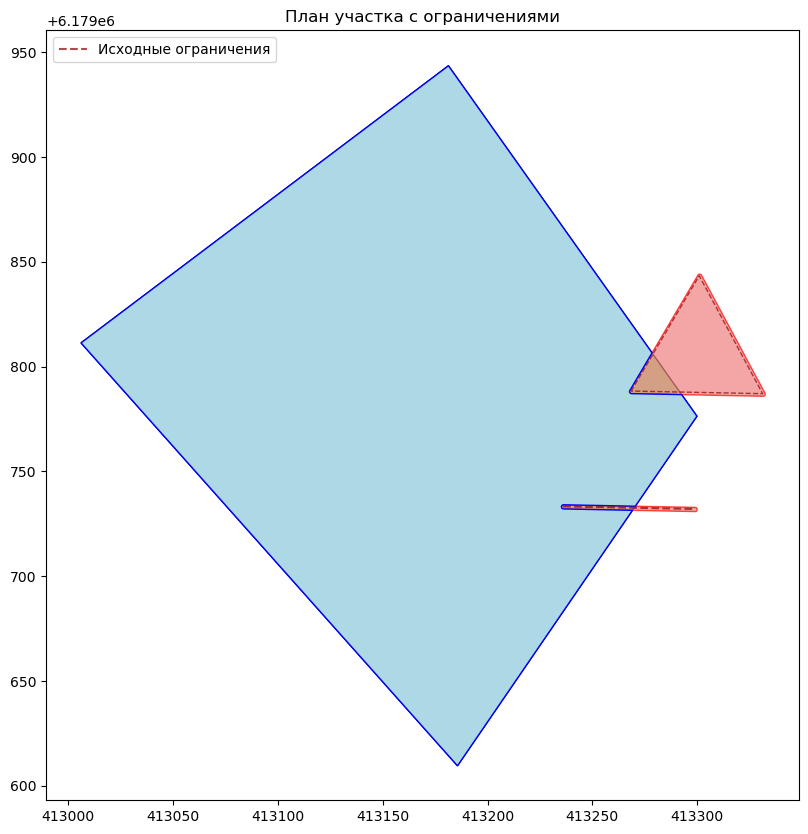

2025-03-08 16:10:49,842 - INFO - Площадь доступной территории: 48673.84 кв.м.
2025-03-08 16:10:49,843 - INFO - Используются следующие соотношения площадей зон: {'residential': 0.7, 'commercial': 0.2, 'park': 0.1}.
2025-03-08 16:10:49,843 - INFO - Целевые площади зон:
2025-03-08 16:10:49,844 - INFO - - residential: 23850.18 кв.м.
2025-03-08 16:10:49,844 - INFO - - commercial: 6814.34 кв.м.
2025-03-08 16:10:49,845 - INFO - - park: 3407.17 кв.м.
2025-03-08 16:10:49,845 - INFO - Участок классифицирован как большой (48673.84 кв.м). Применяется стратегия зонирования для больших участков.
2025-03-08 16:10:49,846 - INFO - Участок большой (48673.84 кв.м), используется стратегия генерации дорог для большой участка.
2025-03-08 16:10:49,849 - INFO - Удалено коротких сегментов дорог общей длиной: 46.46м (минимальная длина сегмента: 54.00м).
2025-03-08 16:10:49,851 - INFO - Дорожная сеть успешно сгенерирована.
2025-03-08 16:10:49,857 - INFO - Зонирование малого участка выполнено.
2025-03-08 16:10:49

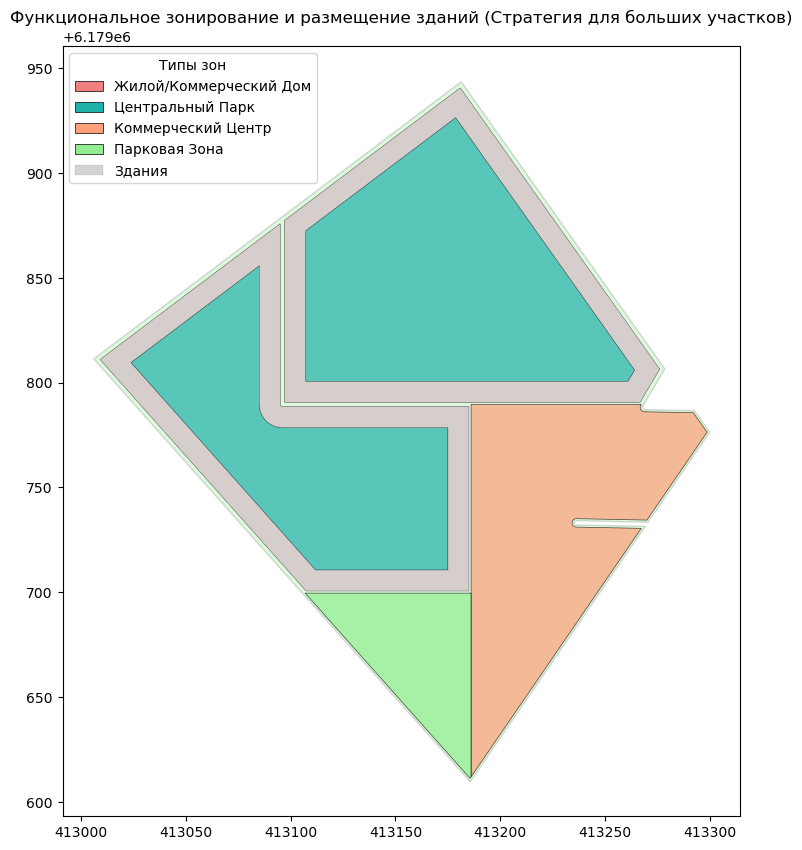

2025-03-08 16:10:50,817 - INFO - Изображение сохранено в файл: F:\Documents\project\project_territory_planning\output\output_zoning_and_buildings_plan.png
2025-03-08 16:10:50,841 - INFO - Результаты зонирования и генерации зданий экспортированы в GeoJSON файл: F:\Documents\project\project_territory_planning\output\output_zoning_and_buildings.geojson


In [94]:
if __name__ == '__main__':
    # Пути к входным и выходным файлам
    filepath = r'F:\Documents\project\project_territory_planning\data\large_area.geojson' # Пример большого участка
    #filepath = r'F:\Documents\project\project_territory_planning\data\small_area.geojson' # Пример малого участка
    output_geojson_filepath = r'F:\Documents\project\project_territory_planning\output\output_zoning_and_buildings.geojson'
    output_image_filepath = r'F:\Documents\project\project_territory_planning\output\output_zoning_and_buildings_plan.png'

    # 1. Загрузка GeoJSON файла с участком и ограничениями
    input_gdf = load_geojson(filepath, TARGET_CRS)

    if input_gdf is None:
        logging.error("Выполнение программы прервано из-за ошибки загрузки GeoJSON.")
    else:
        # 2. Извлечение полигона участка и зон ограничений
        site_polygon, restrictions_gdf = extract_site_and_restrictions(input_gdf)
        if site_polygon is None:
            logging.error("Выполнение программы прервано из-за ошибки извлечения полигона участка.")
        else:
            # 3. Обработка ограничений и визуализация доступной территории
            buildable_area = process_restrictions_and_visualize(site_polygon, restrictions_gdf, RESTRICTION_BUFFER_DISTANCE)
            if buildable_area is None:
                logging.error("Выполнение программы прервано из-за ошибки обработки зон ограничений.")
            else:
                # 4. Определение целевых площадей для функциональных зон
                target_zone_areas = define_zone_types_and_target_areas(buildable_area, DENSITY_LIMIT)
                if target_zone_areas is not None:
                    # 5. Зонирование доступной территории в зависимости от размера участка
                    zoned_gdf = zone_buildable_area_by_size(buildable_area, input_gdf.crs, SMALL_AREA_THRESHOLD)
                    if zoned_gdf is not None:
                        strategy_name = "Стратегия для малых участков" if buildable_area.area <= SMALL_AREA_THRESHOLD else "Стратегия для больших участков"

                        logging.info("\nФункциональное зонирование территории выполнено успешно:")
                        logging.info(zoned_gdf.head()) # Вывод первых строк GeoDataFrame с зонами

                        # 6. Генерация зданий для зон
                        buildings_gdf = generate_buildings_in_zone(zoned_gdf, target_zone_areas, input_gdf.crs)
                        if buildings_gdf is not None:
                            logging.info("\nГенерация зданий выполнена успешно:")
                            logging.info(buildings_gdf.head()) # Вывод первых строк GeoDataFrame со зданиями
                            # 7. Визуализация зонирования и зданий
                            visualize_zoning_with_buildings(buildable_area, zoned_gdf, buildings_gdf, title=f'Функциональное зонирование и размещение зданий ({strategy_name})', output_image_filepath=output_image_filepath)
                            # 8. Экспорт результатов в GeoJSON
                            export_to_geojson(zoned_gdf, buildings_gdf, output_geojson_filepath)
                        else:
                            logging.warning("Генерация зданий не выполнена или не было сгенерировано ни одного здания. Экспорт будет произведен только для зон.")
                            export_to_geojson(zoned_gdf, None, output_geojson_filepath) # Экспорт только зон, если здания не сгенерированы

                    else:
                        logging.error("Ошибка зонирования территории: не удалось выполнить зонирование для данного размера участка.")
                else:
                    logging.error("Ошибка при расчете целевых площадей функциональных зон.")